# $l_1$--regularization
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\renewcommand{\a}{\alpha}             $ 
$\renewcommand{\b}{\beta}              $ 
$\renewcommand{\c}{\gamma}             $ 
$\renewcommand{\d}{\delta}             $ 
$\newcommand{\D}{\Delta}               $ 
$\newcommand{\la}{\lambda}             $ 
$\renewcommand{\t}{\tau}               $ 
$\newcommand{\s}{\sigma}               $ 
$\newcommand{\e}{\varepsilon}          $ 
$\renewcommand{\th}{\theta}            $ 
$\newcommand{\x}{\bar x}               $ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\E}{\mathcal E}           $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\newcommand{\nf}[1]{\nabla f(#1)}     $
$\newcommand{\hx}{\hat x}               $
$\newcommand{\hy}{\hat y}               $
$\DeclareMathOperator{\prox}{prox}      $
$\DeclareMathOperator{\argmin}{argmin}  $
$\DeclareMathOperator{\dom}{dom}        $
$\DeclareMathOperator{\id}{Id}          $
$\DeclareMathOperator{\conv}{conv}      $

We want to minimize:
$$
\min_x \frac 1 2 ||Ax-b||^2 + \lambda  ||x||_1 =: f(Ax)+g(x),
$$
where $A\in \R^{m\times n}$ is a matrix data, $b\in \R^m$ is a given observation, and $x\in \R^n$ is an unknown signal.

We can rewrite the problem above in a primal-dual form as follows:
$$
\min_x \max_y g(x)+(Ax,y)-f^*(y),
$$
where $f(x) = \frac 1 2 ||x-b||^2$, $f^*(y) = \frac 1 2 ||y||^2 + (b,y) = \frac 1 2 ||y+b||^2 -\frac{1}{2}||b||^2$ and $g(x) = \lambda ||x||_1$.

For the problem in a primal-dual form we apply primal-dual methods and for the problem in a primal form we apply proximal gradient method and FISTA. For this we set $h(x) = f(Ax)$ and get $\nabla h(x) = A^*(Ax-b)$.

In [1]:
import scipy.sparse as sr
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt

from scipy import  io
from opt_operators import *
from algorithms import *
from pd_algorithms import *
from misc_for_output import *
%reload_ext autoreload
%autoreload 2

We construct our data in one of the following ways below. We will use a fixed random generator for all our data to make experiments reproducible.

In [2]:
gen = 100
#gen  = np.random.choice(100)

In [3]:
n = 1000
m = 200
s = 10
la = 0.1

np.random.seed(gen)
A = np.random.normal(0,1, (m,n))
np.random.seed(gen)
w = np.random.uniform(-10,10, n)
w[s:] = 0
np.random.seed(gen)
w = np.random.permutation(w)

In [ ]:
n = 2000
m = 1000
s = 100
la = 0.1

np.random.seed(gen)
A = np.random.normal(0,1, (m,n))

np.random.seed(gen)
w = np.random.uniform(-10,10, n)

#w = np.random.normal(0,1, n)
w[s:] = 0
np.random.seed(gen)
w = np.random.permutation(w)

For the problem below we took $p = 0.5$ or $p = 0.9$

In [ ]:
# In the paper p = 0.5  or p = 0.9

n = 5000
m = 1000
s = 50
la = 0.1

np.random.seed(gen)
B = np.random.normal(0,1, (m,n))
p = 0.9
A = np.zeros((m,n))
A[:,0] = B[:,0]/np.sqrt(1-p**2)
for j in np.arange(1,n):
    A[:,j] = p*A[:,j-1] + B[:,j]

np.random.seed(gen)
w = np.random.uniform(-10,10, n)
w[s:] = 0
np.random.seed(gen)
w = np.random.permutation(w)

Define $\nu$ and $b$

In [4]:
np.random.seed(gen)
nu = np.random.normal(0,0.1, m)
b = A.dot(w) + nu

Define all ingredients for primal-dual methods and proximal gradient-like

In [5]:
def f_conj(y):
    return 0.5*(y+b).dot(y+b)

def g(x):
    return la*LA.norm(x,1)

def prox_g(x, rho):
    return prox_norm_1(x,la*rho)

def prox_f_conj(y, rho):
    return (y - rho*b)/(1+rho)

# define energy 
def J(x,y):
    t = A.dot(x)-b
    return 0.5* t.dot(t) + la* LA.norm(x,1)

def J1(y,x):
    return J(x,y)


#### for proximal gradient method and FISTA
def h(x):
    t = A.dot(x)-b
    return 0.5 * t.dot(t)


def dh(x):
    return A.T.dot(A.dot(x)-b)

def F(x):
    return J(x,1)

Compute matrix norm of operator $A$. This may be long if you consider large-scale problems.

In [6]:
L = np.sqrt(np.max(LA.eigh(A.dot(A.T))[0]))

In [7]:
# number of iterations
N = 1000

# starting points
x0 = np.zeros(n)
y0 = -b

# step size for PDA
tau = 1./L
sigma = 1./L

# step size for PDAL (doesn't require any expensive computation)
tau0 = np.sqrt(m)/LA.norm(A)

# step size for FISTA
alpha = 1./L**2

In [8]:
N = 15000
ans1 = pd(J, prox_g, prox_f_conj, A, x0, y0, 0.05*sigma, 20*tau, numb_iter=N)
ans2 =  pd_linesearch_dual_is_square_norm(J, prox_g, -b, A, x0, y0 , tau, 1./400, numb_iter=N)
ans3 = pd_accelerated_primal(J1, prox_f_conj, prox_g, -A.T, y0, x0, tau, sigma, 0.1,   numb_iter=N)
ans4 = pd_linesearch_acceler_dual_is_square_norm(J, prox_g, -b, A,  x0, y0, tau0, 1, gamma=0.1, numb_iter=N)
ans5 = fista(F, dh, prox_g, x0, alpha, numb_iter=N)
ans6 = sparsa(F, h, dh, prox_g, x0, alpha, numb_iter=N,time_bound=3000)
#ans7 = prox_grad(F, dh, prox_g, x0, alpha, numb_iter=N)



----- Primal-dual method -----
Time execution: 19.491676
----- Primal-dual method with  linesearch. f^*(y)=0.5*||y-b||^2-----
Time execution: 34.053145594
----- Accelerated primal-dual method (g(x) is strongly convex)-----
Time execution: 32.918488122
----- Accelerated primal-dual method with  linesearch for dual f^*(y)=0.5*||y-b||^2-----
Time execution: 35.22291397400001
---- FISTA----
Time execution: 19.864797757999995


Quick results. They are not very informative:

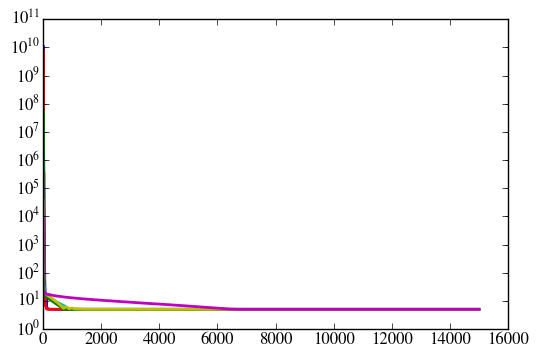

In [9]:
plt.plot(ans1[1], 'b',)
plt.plot(ans2[1], 'r',)
plt.plot(ans3[1], 'c',)
plt.plot(ans4[1], 'g',)
plt.plot(ans5[1], 'y',)
plt.plot(ans6[1], 'm',)
plt.yscale('log')
plt.show()

Define all labels and define the time stamp (in seconds) to which we want to present our results


In [10]:
answers = [ans1, ans2, ans3, ans4, ans5, ans6]
alg = ["PDA", "PDAL", "APDA", "APDAL",  "FISTA", "SPARSA"]

time_stamp = 15

To see the plots of residual $f(Ax)+g(x) - f(Ax^*)-g(x^*)$. For simplicity, we just set $v_{min} = f(Ax^*)+g(x^*)$ as the smallest number among all energy values for all methods during all iterations. Alternatively, one can increase number of iterations to obtain even better ground truth solution.

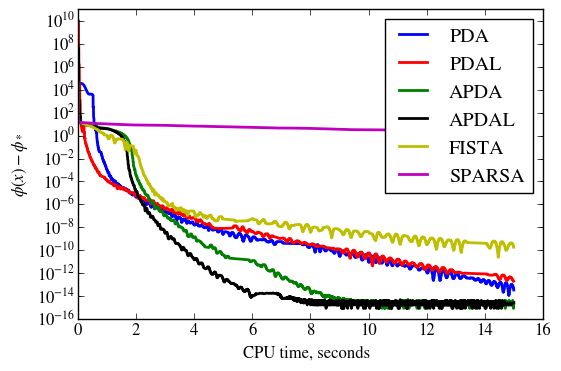

In [13]:
a1,a2 = cut_time(ans1[0],ans1[1], t=time_stamp)
b1,b2 = cut_time(ans2[0],ans2[1], t=time_stamp)
c1,c2 = cut_time(ans3[0],ans3[1], t=time_stamp)
d1,d2 = cut_time(ans4[0],ans4[1], t=time_stamp)
e1,e2 = cut_time(ans5[0],ans5[1], t=time_stamp)
f1,f2 = cut_time(ans6[0],ans6[1], t=time_stamp)


v_min = find_smallest_energy(answers)

plt.plot(a1, a2-v_min, 'b', label=alg[0])
plt.plot(b1, b2-v_min, 'r', label=alg[1])
plt.plot(c1, c2-v_min, 'g', label=alg[2])
plt.plot(d1, d2-v_min, 'k', label=alg[3])
plt.plot(e1, e2-v_min, 'y', label=alg[4])
plt.plot(f1, f2-v_min, 'm', label=alg[5])

plt.yscale('log')
plt.xlabel(u'CPU time, seconds  ')
plt.ylabel(u'$\phi(x)-\phi_*$')

plt.legend()
plt.savefig('figures/lasso-?.pdf',bbox_inches='tight')
plt.show()
plt.clf()

Check how sparse is your solution (obtained for example from PDAL) and how it is different from $w$:

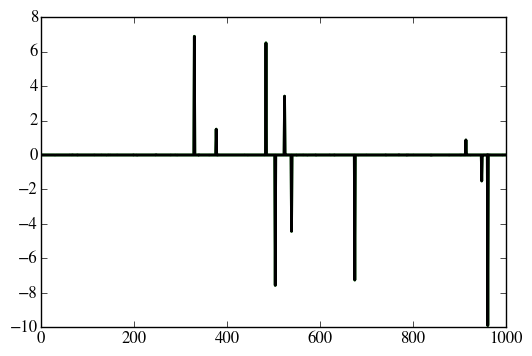

In [14]:
plt.plot(w, 'g')
plt.plot(ans2[2], 'k')
plt.show()